In [1]:
#importing the necessary modules
import torch
import torchvision
from torchvision import transforms,datasets

import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import cv2

## Data Exploration

In [2]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('Train .csv')
test_data = pd.read_csv('Test .csv')
train_path = 'train/1/'
test_path = 'test/1/'

In [3]:
# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']


In [15]:
train.head()

,filepath,LABEL,ID
0,train/1/VTYNBFTO.png,Positive,VTYNBFTO
1,train/1/GVVXXDOZ.png,Normal,GVVXXDOZ
2,train/1/PMRSQLXN.png,Normal,PMRSQLXN
3,train/1/JXISWDUU.png,Positive,JXISWDUU
4,train/1/JVWMAACC.png,Positive,JVWMAACC


In [5]:
test.head()

,filepath,ID
0,test/1/GTWSHFYQ.png,GTWSHFYQ
1,test/1/QTFSSMGD.png,QTFSSMGD
2,test/1/TBLBHSYT.png,TBLBHSYT
3,test/1/ZKETEOFG.png,ZKETEOFG
4,test/1/GKTPBGZP.png,GKTPBGZP


In [6]:
print("Train data shape is ",train.shape)
print("Test data  shape is ",test.shape)

Train data shape is  (718, 3)
Test data  shape is  (82, 2)


/home/gerald/anaconda3/envs/tb_zindi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


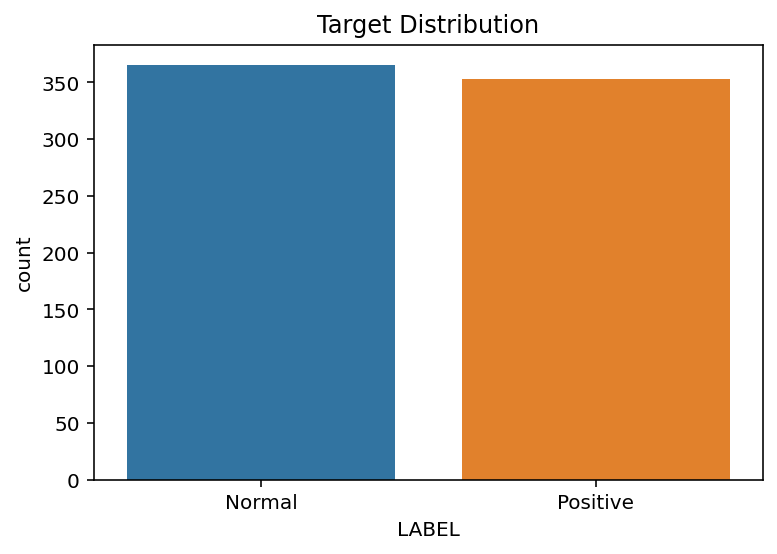

In [7]:
## EDA & PREPROCESSING
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

### Observation
* Our target column seems to be well balanced in the data set

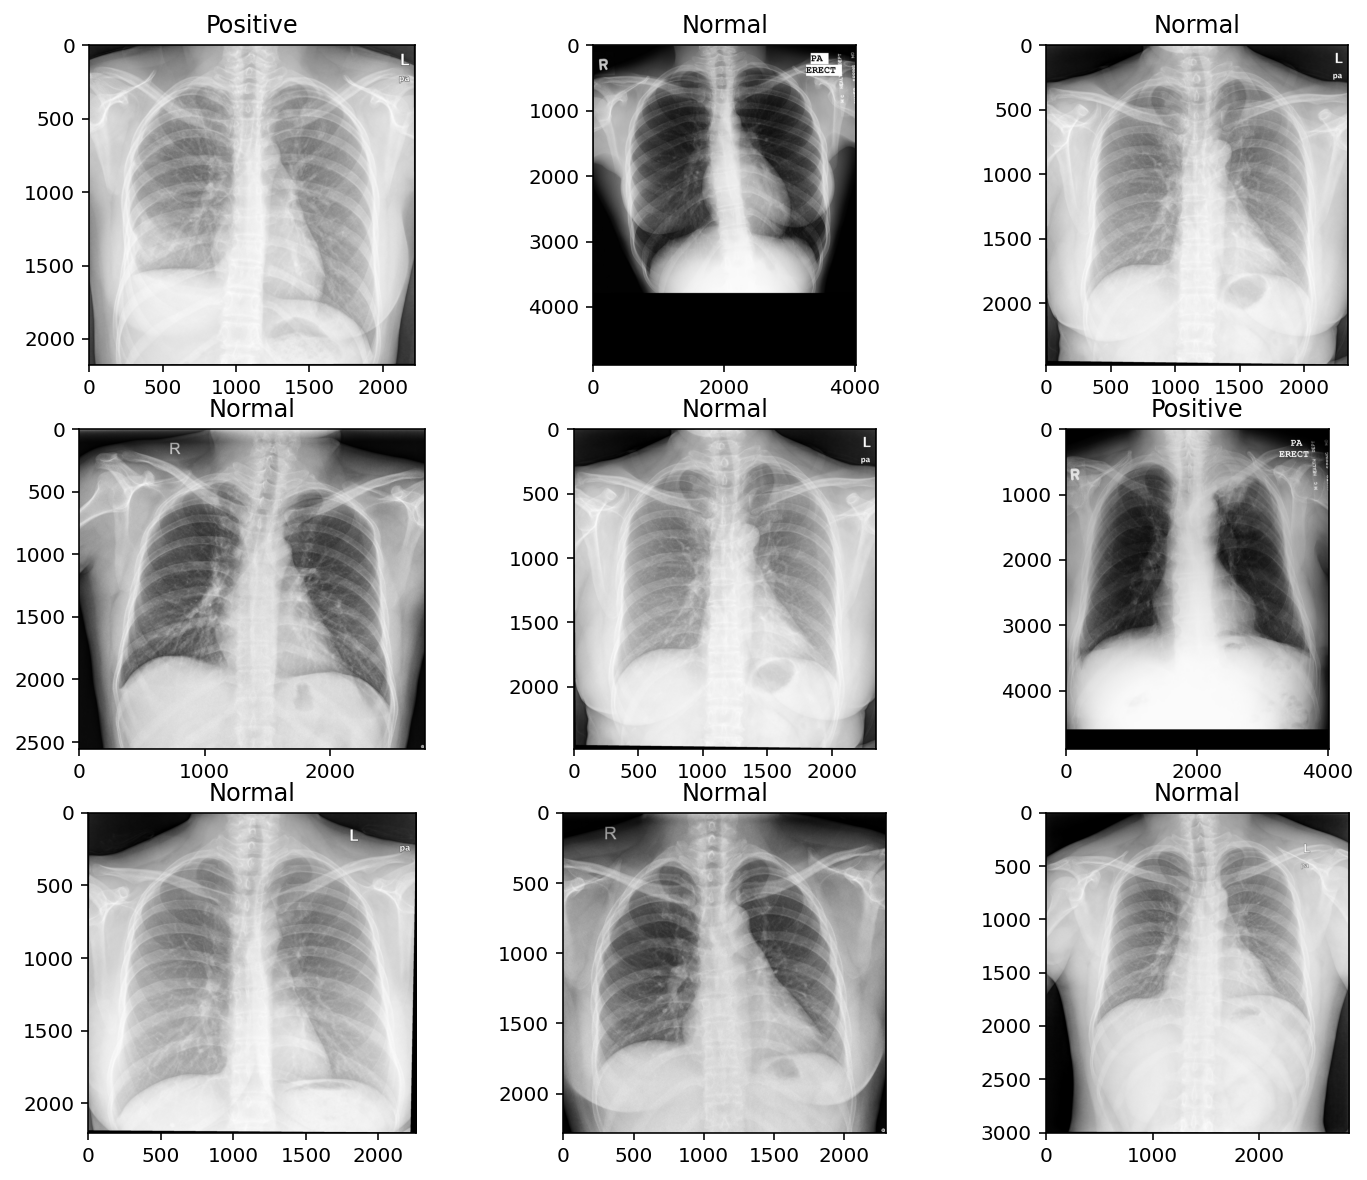

In [8]:
#Visualizing random images

#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [9]:
#creating a tranform object to convert our image to tensors
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

In [10]:
#getting our train and test data and converting it to tensors
train_data = datasets.ImageFolder('train/',transform = train_transform)
#test_data = torchvision.datasets.ImageFolder('test/',transform = test_transform)
valid_data = torchvision.datasets.ImageFolder('train/',transform = test_transform)

In [11]:
#Splitting the training data into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))

#shuffling the data
np.random.shuffle(indices)

#using the SubsetRandomSampler for the split
from torch.utils.data.sampler import SubsetRandomSampler

#our validation size is 20% of training data
validation_size = 0.2
split = int(np.floor(validation_size * num_train))
train_split,val_split = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_split)
test_sampler = SubsetRandomSampler(val_split)
trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size = 32)
validationloader = torch.utils.data.DataLoader(valid_data,sampler=test_sampler,batch_size = 32)


In [12]:
print(trainloader.dataset.classes)

['1']


In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/gerald/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Loading our dataset